In [42]:
import logging
import os
import sys
from typing import Generator, Iterator, Literal, Union

import httpx
import torch
from pydantic import BaseModel

from llama_index.core import (
    Settings,
    SimpleDirectoryReader,
    VectorStoreIndex,
    load_index_from_storage,
)
from llama_index.core.base.llms.types import ChatMessage
from llama_index.core.chat_engine import CondensePlusContextChatEngine
from llama_index.core.chat_engine.types import BaseChatEngine
from llama_index.core.indices.base import BaseIndex
from llama_index.core.node_parser import HierarchicalNodeParser, MarkdownNodeParser
from llama_index.core.storage import StorageContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.groq import Groq
from llama_index.llms.ollama import Ollama
from llama_index.llms.openai_like import OpenAILike

import openai

In [3]:
questions = [
    "O que é um laço?",
    "O que são algoritmos?",
    "Qual a diferença entre while e do-while?",
    "Meu código não está funcionando.",
    "O que são métodos? Como os utilizo?",
    "Qual é a vantagem de usar métodos em programação?",
    "O que é um erro de compilação?",
    "Por que meu programa está travando?",
    "Por que meu programa dá o resultado errado mesmo compilando?",
    "Para que serve a classe Scanner?",
    "Como eu imprimo na tela?",
    "O que são ifs aninhados?",
    "Como eu escrevo um algoritmo para resolver um problema?",
    "O que é uma classe?",
    "Como eu crio e uso classes no meu programa?",
    "O que é um array?",
    "O que é uma rede neural?",
    "O que é uma variável e como eu a declaro?",
    "Qual a diferença entre uma variável local e uma global?",
    "Como que eu leio um arquivo?",
    "Para que serve o comando switch-case?",
    "O que é um loop infinito?",
    "Como eu faço para tratar exceções?",
    "Qual a diferença entre while e for?",
    "Como eu faço para conectar ao banco de dados?",
    "O que é polimorfismo em programação orientada a objetos?",
    "Como eu faço para debugar meu código no BlueJ?",
    "O que é um framework?",
    "Como eu faço para usar funções recursivas?",
    "Como eu faço para ordenar um vetor?",
    "O que são atributos em uma classe?",
    "Como eu faço para criar uma interface gráfica em Java?",
    "O que é encapsulamento?",
    "Qual a diferença entre memória heap e stack?",
    "Como eu faço para implementar herança?",
    "O que é pensamento computacional?",
    "O que é um algoritmo de busca?",
    "Qual a utilidade da tabela verdade?",
    "O que é uma função?",
    "Como eu utilizo operadores aritméticos?",
    "O que é uma constante?",
    "Qual a diferença entre um inteiro e um float?",
    "O que são operadores lógicos?",
    "Como eu faço para converter tipos de dados?",
    "O que é um ponteiro?",
    "Como eu faço para manipular strings?",
    "O que são estruturas de controle de fluxo?",
    "Qual a diferença entre um vetor e uma matriz?",
    "Como eu faço para iterar sobre uma lista?",
    "O que é um módulo?",
    "Como eu faço para usar bibliotecas externas?",
    "O que é um comentário?",
    "Qual a diferença entre compilar e interpretar um programa?",
    "Como eu faço para medir o tempo de execução de um código?",
    "O que são parâmetros e argumentos em funções?",
    "Como eu faço para depurar um erro de lógica?",
    "O que são padrões de projeto?",
    "O que é teste de mesa?",
    "O que é teste de mesa?",
]

## Setup do host

No Brev.dev, as máquinas tem que ser configuradas com SSH e Ollama da seguinte forma.

### Ollama

Ele vai reclamar. Não tem problema.

```shell
$ sudo curl -L https://ollama.com/download/ollama-linux-amd64 -o /usr/bin/ollama
$ sudo chmod +x /usr/bin/ollama
$ OLLAMA_HOST=0.0.0.0 OLLAMA_NUM_PARALLEL=2 OLLAMA_KEEP_ALIVE=2h ollama serve &
$ ollama pull llama3:70b-instruct-q8_0
```

### SSH

Na tua máquina, com o Brev instalado:

```shell
$ brev port-forward $BREV_HOST -p 11435:11434
```

Nesse caso, `$BREV_HOST` é `tcc`.

In [95]:
ollama = openai.AsyncOpenAI(base_url="http://localhost:11435/v1", api_key="ollama")

In [96]:
stream = await ollama.chat.completions.create(
    stream=True,
    model="llama3:70b-instruct-q8_0",
    messages=[
        {
            "role": "user",
            "content": "hi",
        } 
    ],
)

async for chunk in stream:
    print(chunk.choices[0].delta.content or "", end="")

Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?

In [85]:
llm = openai.AsyncOpenAI(base_url="http://10.88.190.244:9099", api_key="0p3n-w3bu!")

In [99]:
import pandas as pd

In [136]:
responses = []
for q in questions:
    for _ in range(15):
        stream = await llm.chat.completions.create(
            stream=True,
            model="llama_index_retrieval_pipeline",
            messages=[
                {
                    "role": "user",
                    "content": q,
                }
            ],
        )

        resp = ""
        async for chunk in stream:
            resp += chunk.choices[0].delta.content or ""

        responses.append({"query": q, "response": resp})

In [137]:
scores: list[dict[str, str | int]] = list()

for qr in responses:
    q = qr["query"]
    resp = qr["response"]

    stream = await ollama.chat.completions.create(
        stream=True,
        model="llama3:70b-instruct-q8_0",
        messages=[
            {
                "role": "system",
                "content": "Analyze the following exchange and give it a grade from 0 to 10. Only respond with a number.",
            },
            {"role": "user", "content": q},
            {"role": "system", "content": resp},
        ],
    )

    while True:
        quality = ""
        async for chunk in stream:
            quality += chunk.choices[0].delta.content or ""

        try:
            scores.append({"query": q, "response": resp, "score": int(quality)})
            break
        except ValueError as e:
            print(e)
            continue

In [138]:
queries_pd = pd.DataFrame(scores, columns=["query", "response", "score"])

In [145]:
sorted_df = queries_pd.sort_values(by="score", ascending=False)

In [140]:
queries_pd.to_csv("queries.csv", index=False)

In [175]:
described_df = sorted_df.groupby('query')['score'].describe().sort_values(by='mean', ascending=False)

In [176]:
described_df

,count,mean,std,min,25%,50%,75%,max
query,,,,,,,,
Qual a diferença entre um vetor e uma matriz?,15.0,8.866667,0.743223,8.0,8.0,9.0,9.0,10.0
O que são algoritmos?,15.0,8.400000,0.736788,8.0,8.0,8.0,8.5,10.0
O que é encapsulamento?,15.0,8.400000,0.507093,8.0,8.0,8.0,9.0,9.0
O que são ifs aninhados?,15.0,8.266667,0.457738,8.0,8.0,8.0,8.5,9.0
Qual a diferença entre while e do-while?,15.0,8.266667,0.593617,8.0,8.0,8.0,8.0,10.0
Como eu faço para medir o tempo de execução de um código?,15.0,8.266667,0.457738,8.0,8.0,8.0,8.5,9.0
O que é um módulo?,15.0,8.200000,0.414039,8.0,8.0,8.0,8.0,9.0
Para que serve o comando switch-case?,15.0,8.133333,0.351866,8.0,8.0,8.0,8.0,9.0
O que são padrões de projeto?,15.0,8.133333,0.351866,8.0,8.0,8.0,8.0,9.0


In [242]:
sub_df = described_df.sample(frac=0.1)

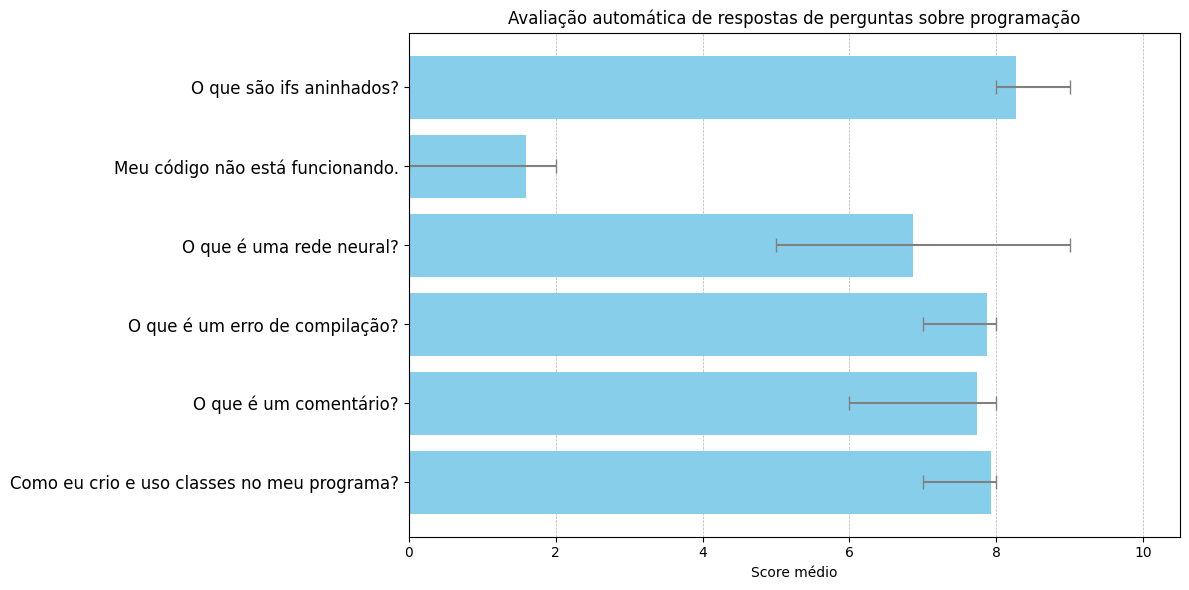

In [256]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
ax = plt.gca()

errors = sub_df['max'] - sub_df['min']

plt.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax.set_xlim(0, 10.5)

ax.barh(sub_df.index, sub_df['mean'], color='skyblue', zorder=2)
ax.errorbar(sub_df['min'], sub_df.index, xerr=[np.zeros(len(errors)), errors], fmt='none', ecolor='gray', capsize=5, label='Variação do score')
ax.invert_yaxis()
plt.xlabel('Score médio')
plt.title('Avaliação automática de respostas de perguntas sobre programação')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('scores2.png', dpi=300)
plt.show()

In [292]:
len(data1)

29

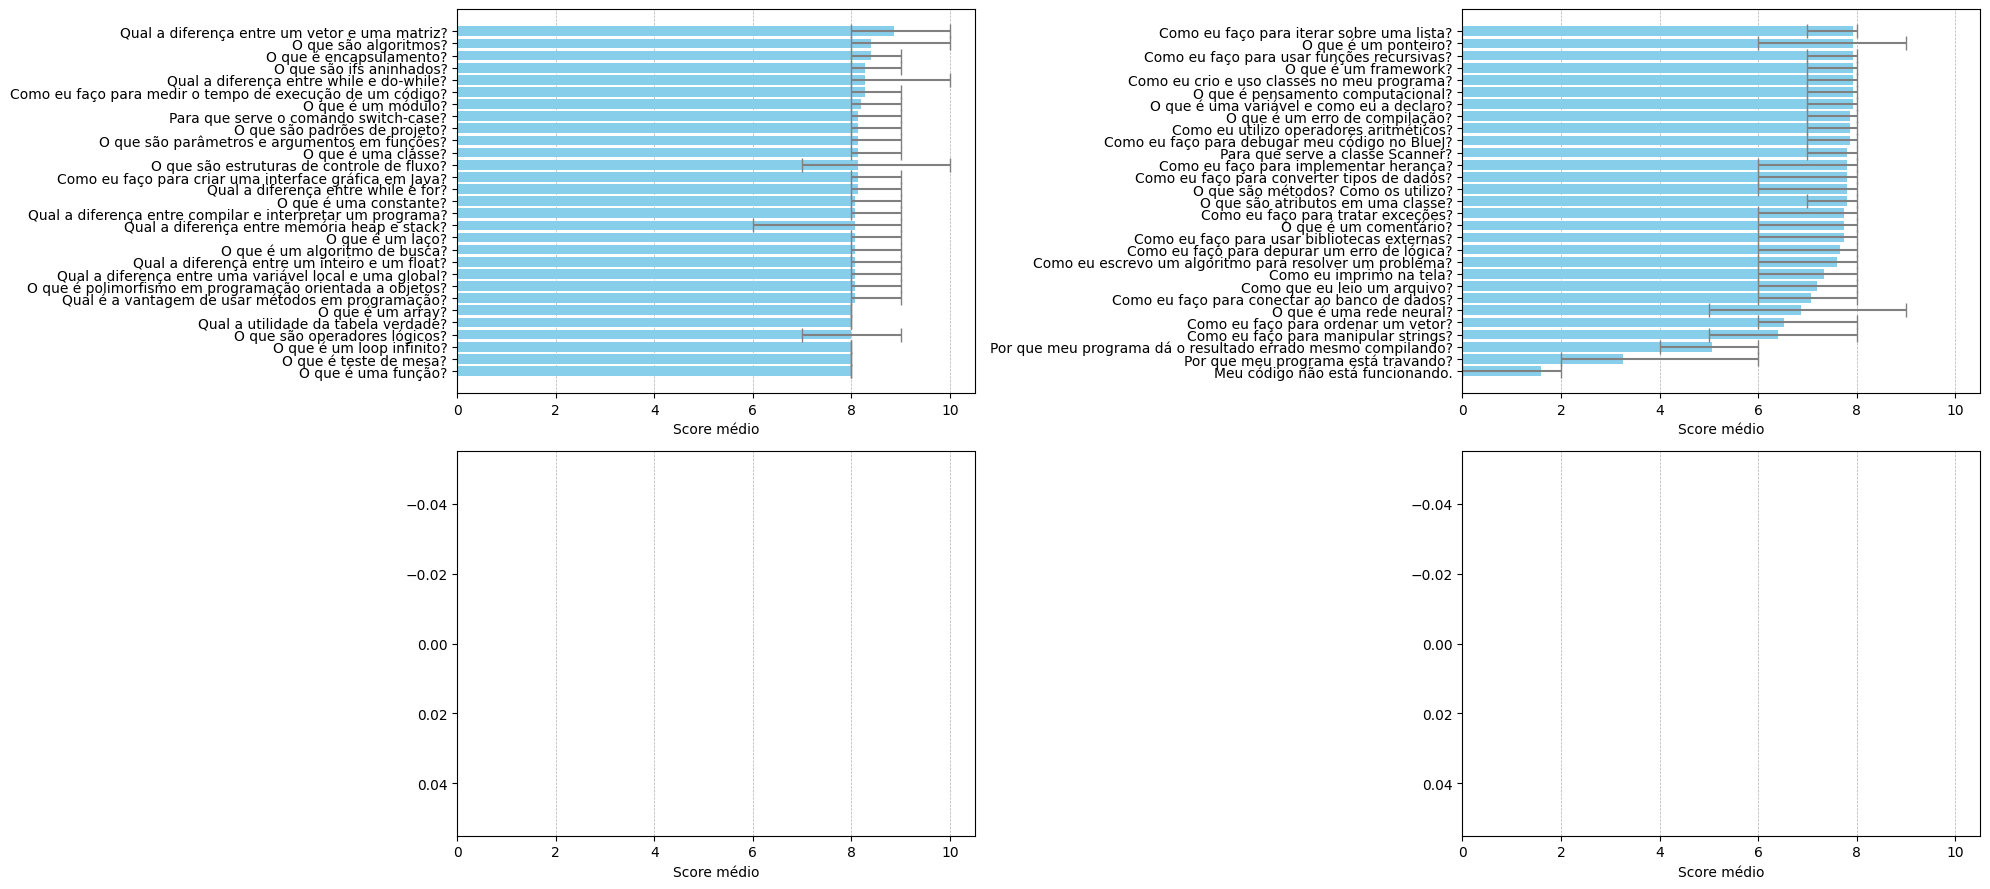

In [324]:
import matplotlib.pyplot as plt
import numpy as np

part_size = len(described_df) // 2
remainder = len(described_df) % 2

data1 = described_df[:part_size]
data2 = described_df[part_size:2*part_size]
data3 = described_df[2*part_size:3*part_size]
data4 = described_df[3*part_size:4*part_size + remainder]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 9))

for ax, _df in zip([ax1, ax2, ax3, ax4], [data1, data2, data3, data4]):
    errors = _df['max'] - _df['min']

    ax.grid(axis='x', linestyle = '--', linewidth = 0.5)
    ax.set_xlim(0, 10.5)

    ax.barh(_df.index, _df['mean'], color='skyblue', zorder=2)
    ax.errorbar(_df['min'], _df.index, xerr=[np.zeros(len(errors)), errors], fmt='none', ecolor='gray', capsize=5, label='Variação do score')
    ax.invert_yaxis()
    ax.set_xlabel('Score médio')

# ax1.set_yticklabels(fontsize=12)

plt.tight_layout()
plt.savefig('scoresall.png', dpi=400)
plt.show()

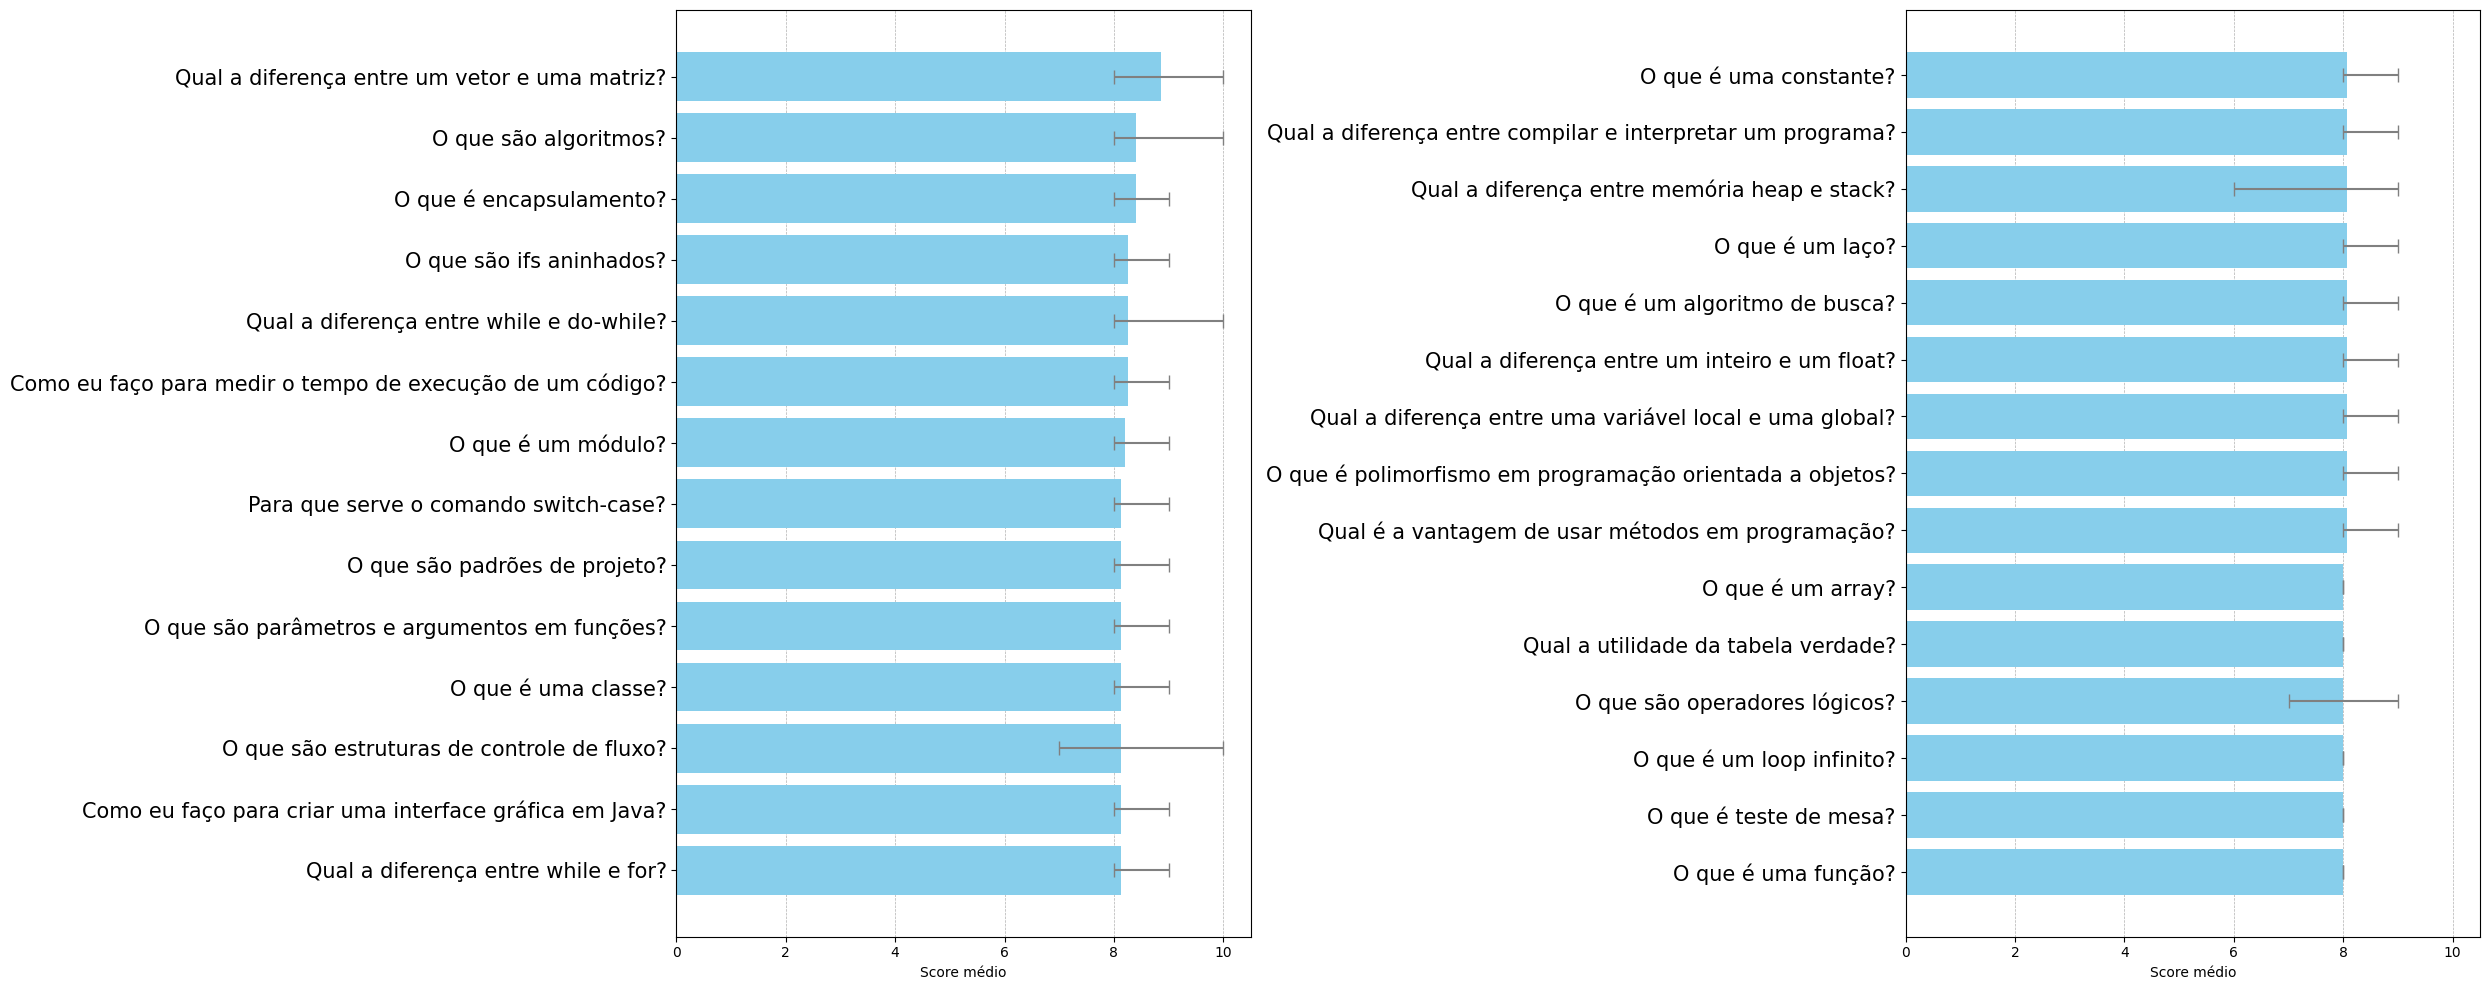

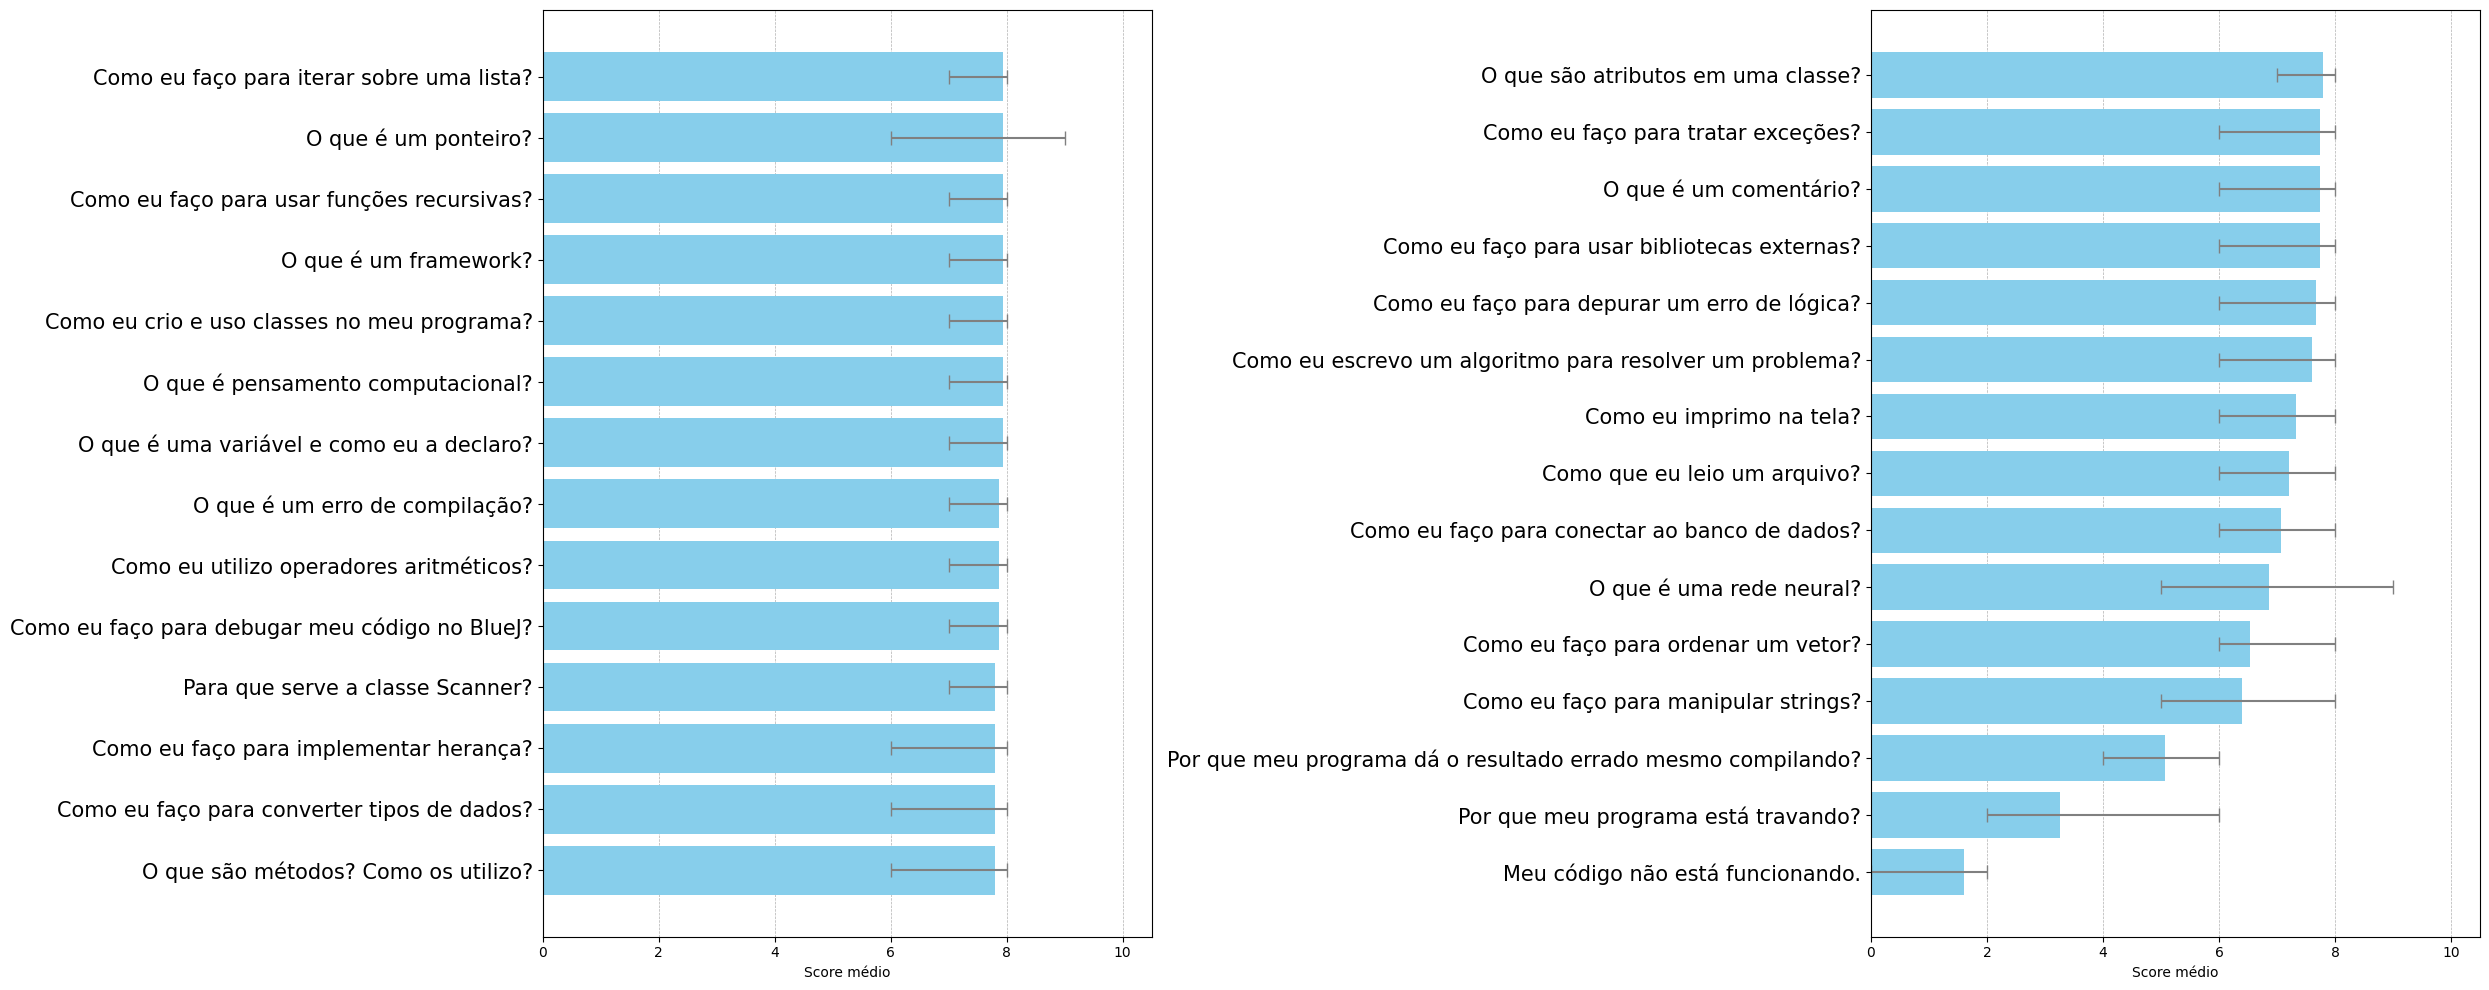

In [351]:
import matplotlib.pyplot as plt
import numpy as np

for __df in [described_df[:len(described_df) // 2], described_df[len(described_df) // 2:]]:
    part_size = len(__df) // 2
    remainder = len(__df) % 2

    data1 = __df[:part_size]
    data2 = __df[part_size:2*part_size + remainder]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

    for ax, _df in zip([ax1, ax2], [data1, data2]):
        errors = _df['max'] - _df['min']

        ax.grid(axis='x', linestyle = '--', linewidth = 0.5)
        ax.set_xlim(0, 10.5)

        ax.barh(_df.index, _df['mean'], color='skyblue', zorder=2)
        ax.errorbar(_df['min'], _df.index, xerr=[np.zeros(len(errors)), errors], fmt='none', ecolor='gray', capsize=5, label='Variação do score')
        ax.invert_yaxis()
        ax.set_xlabel('Score médio')

        ax.tick_params('y', labelsize=15)

    plt.tight_layout()
    plt.savefig(f'scoresall_{__df.iloc[0].name[0:3]}.png', dpi=400)
    plt.show()